In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
import matplotlib
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)
%matplotlib inline

import os
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale = 0.8)

In [2]:
## import from adp.py
os.chdir(r'C:\Users\ll357\Documents\inter'.replace('\\', '/'))
# %pip install -e .
from src import adp

# dir & metadata

In [3]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')
dir_test = dir_data + r'\test'.replace('\\', '/')
dir_test

'//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/mat_inter/test'

In [4]:
def read_csv_by_stim_type():
    """
    read csv file containing metadata of recordings, including stim type 

    returns:
        df (pandas dataframe): dataframe of recordings for each stim type
    """
    # read metadata of segmented sessions
    dir_inter = r"C:\Users\ll357\Documents\inter\data".replace("\\", "/")
    df = pd.read_csv(dir_inter + "/batch_cellpose.csv")
    # only keep segmented data
    df = df[(df.manual_seg == 1) | (df.cellpose_seg == 1)].reset_index(drop=True)
    # separate by stim type
    df_bun = df[df["stim_type"] == "bunny"]
    df_grat = df[(df["stim_type"] == "grating")]
    return df, df_bun, df_grat

In [5]:
# read csv
from src import adp
df, df_bun, df_grat = read_csv_by_stim_type()
df_bun

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,stim_type
0,1338,210616,V1,200,2.0,1.0,NaN,bunny6,6s,bunny
1,1339,210922,V1,200,2.0,1.0,NaN,bunny500,6s,bunny
2,1350,211222,V1,200,2.0,1.0,NaN,bunnytop,6s,bunny
3,1350,220225,V1,200,2.0,1.0,NaN,bunnytop high res,6s,bunny
4,1369,220310,V1,200,2.0,1.0,NaN,bunnytop high res,6s,bunny
5,1372,220406,V1,200,2.0,1.0,NaN,bunnytop high res high lum-contrast,6s,bunny


# trace by dataset

### cellpose bunny V1 gcamp6s

In [6]:
def calc_trace_stim(trace_by_trial, stim_id):
    """
    calculate mean trace and mean trace by stim.
    args:
        trace_by_trial (ndarray): neural activity of shape: ncell x ntrial x nframe
        stim_id (ndarray): stim identity for each trial
    returns:
        trace_mean (ndarray): mean neural activity of shape: ncell x nframe
        trace_by_stim (ndarray): mean neural activity of shape: nstim x ncell x nframe
    """

    # trace over all stims
    trace_cell_avg = np.mean(np.mean(trace_by_trial, axis=0), axis=0)

    # trace for each stim
    trace_stim_avg = []
    for i in np.unique(stim_id):
        trace_istim_avg = np.mean(trace_by_trial[:, np.where(stim_id == i)[0]], axis=1)
        trace_istim_avg = np.mean(trace_istim_avg, axis=0)
        trace_stim_avg.append(trace_istim_avg)
    print(len(trace_stim_avg), trace_stim_avg[0].shape)

    return trace_cell_avg, trace_stim_avg

In [7]:
trace_avg = []
mouse_list = []
date_list = []
for i in np.arange(df_grat.shape[0]):
    mouse = df_bun.iloc[i].mouse.astype(str)
    date = df_bun.iloc[i].date.astype(str) 
    date = date + '_cellpose' if df_bun.iloc[i].cellpose_seg == 1 else date
    print(mouse, date)
    mouse_list.append(mouse)
    date_list.append(date)

    dir_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i{}_{}'.format(mouse, date)
    stim_id, trace_by_trial = adp.load_trace_trial_data(dir_path)
    trace_avg_cell, trace_stim_avg = calc_trace_stim(trace_by_trial, stim_id)
    trace_avg_cell = (trace_avg_cell - min(trace_avg_cell)) / (max(trace_avg_cell) - min(trace_avg_cell))
    trace_avg.append(trace_avg_cell)
len(trace_avg)

1338 210616_cellpose
ncell: 75, nstim: 7, ntrial: 1273, nframe: 77
7 (77,)
1339 210922_cellpose
ncell: 95, nstim: 500, ntrial: 727, nframe: 137
500 (137,)
1350 211222_cellpose
ncell: 70, nstim: 30, ntrial: 487, nframe: 143
30 (143,)
1350 220225_cellpose
ncell: 19, nstim: 30, ntrial: 557, nframe: 143
30 (143,)
1369 220310_cellpose
ncell: 111, nstim: 30, ntrial: 511, nframe: 156
30 (156,)
1372 220406_cellpose
ncell: 122, nstim: 30, ntrial: 639, nframe: 156
30 (156,)


6

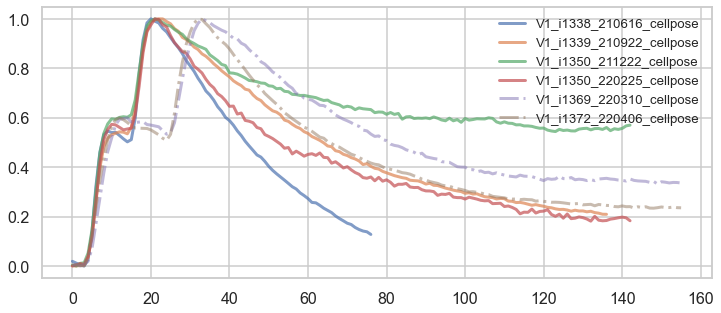

In [27]:
plt.figure(figsize=(12, 5))
for i in np.arange(df_bun.shape[0]-2): # last 2 dataset used slow stim long ISI
    plt.plot(trace_avg[i], alpha=0.7, linewidth=3, label=r'V1_i{}_{}'.format(mouse_list[i], date_list[i]))
for i in np.arange(df_bun.shape[0]-2, df_bun.shape[0]): # last 2 dataset used slow stim long ISI
    plt.plot(trace_avg[i], alpha=0.5, linewidth=3, linestyle='-.', label=r'V1_i{}_{}'.format(mouse_list[i], date_list[i]))
plt.legend(frameon=False);
# plt.savefig(dir_inter + '/results/student seminar/trace_bunny_datasets.pdf')

### mostly manual grating V1 gcamp6s

In [9]:
trace_avg = []
mouse_list = []
date_list = []
for i in np.arange(df_grat.shape[0]):
    mouse = df_grat.iloc[i].mouse.astype(str)
    date = df_grat.iloc[i].date.astype(str) 
    date = date + '_cellpose' if df_grat.iloc[i].cellpose_seg == 1 else date
    print(mouse, date)
    mouse_list.append(mouse)
    date_list.append(date)

    dir_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i{}_{}'.format(mouse, date)
    stim_id, trace_by_trial = adp.load_trace_trial_data(dir_path)
    trace_avg_cell = np.mean(np.mean(trace_by_trial, axis=0), axis=0)
    trace_avg_cell = (trace_avg_cell - min(trace_avg_cell)) / (max(trace_avg_cell) - min(trace_avg_cell))
    trace_avg.append(trace_avg_cell)
len(trace_avg)

1322 200803
ncell: 84, nstim: 8, ntrial: 21, nframe: 207
1323 200720
ncell: 43, nstim: 8, ntrial: 18, nframe: 206
1324 200728
ncell: 65, nstim: 8, ntrial: 25, nframe: 206
1328 201015
ncell: 44, nstim: 8, ntrial: 28, nframe: 207
1329 201209
ncell: 91, nstim: 8, ntrial: 20, nframe: 207
1337 210120_cellpose
ncell: 51, nstim: 8, ntrial: 25, nframe: 206


6

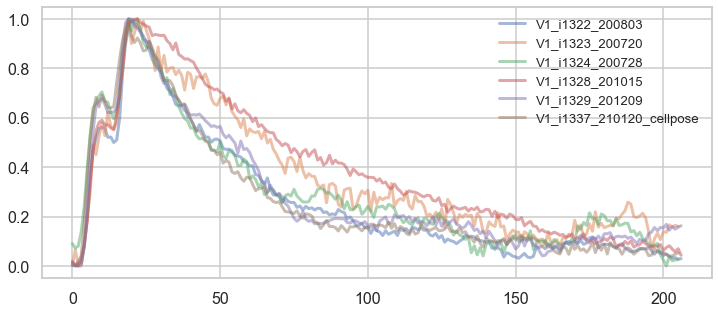

In [29]:
plt.figure(figsize=(12, 5))
for i in np.arange(df_grat.shape[0]): # last 2 dataset used slow stim long ISI
    plt.plot(trace_avg[i], alpha=0.5, linewidth=3, label=r'V1_i{}_{}'.format(mouse_list[i], date_list[i]))
plt.legend(frameon=False);
# plt.savefig(dir_inter + '/results/student seminar/trace_grat_datasets.pdf')

# trace grand avg across datasets
using (df_bun.shape[0]-2) datasets  
concat trace_by_trial on cell axis  
plot avg & sem

## bunny

In [20]:
trace_by_trial_all = []

for i in np.arange(df_bun.shape[0] - 2): # last 2 dataset used slow stim long ISI
    mouse = df_bun.iloc[i].mouse.astype(str)
    date = df_bun.iloc[i].date.astype(str) + '_cellpose'
    print(mouse, date)

    dir_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i{}_{}'.format(mouse, date)
    stim_id, trace_by_trial = adp.load_trace_trial_data(dir_path)

    trace_by_cell = np.mean(trace_by_trial, axis=1)
    trace_by_trial_all.append(trace_by_cell)
    
len(trace_by_trial_all), [trace_by_trial_all[i].shape for i in np.arange(len(trace_by_trial_all))]

1338 210616_cellpose
ncell: 75, nstim: 7, ntrial: 1273, nframe: 77
1339 210922_cellpose
ncell: 95, nstim: 500, ntrial: 727, nframe: 137
1350 211222_cellpose
ncell: 70, nstim: 30, ntrial: 487, nframe: 143
1350 220225_cellpose
ncell: 19, nstim: 30, ntrial: 557, nframe: 143


(4, [(75, 77), (95, 137), (70, 143), (19, 143)])

In [21]:
trial_len_min = np.min([trace_by_trial_all[i].shape[1] for i in np.arange(len(trace_by_trial_all))])
print(trial_len_min)
trace_by_trial_all = [trace_by_trial_all[i][:,:trial_len_min] for i in np.arange(len(trace_by_trial_all))]
[trace_by_trial_all[i].shape for i in np.arange(len(trace_by_trial_all))]

77


[(75, 77), (95, 77), (70, 77), (19, 77)]

In [22]:
trace_all = np.concatenate(trace_by_trial_all, axis=0)
trace_grand_avg = np.mean(trace_all, axis=0)
trace_grand_sem = np.std(trace_all, axis=0) / np.sqrt(trace_all.shape[0])
trace_all.shape, trace_grand_avg.shape, trace_grand_sem.shape

((259, 77), (77,), (77,))

In [ ]:
# plt.rcParams.update(plt.rcParamsDefault)
# plt.figure(figsize=(8,5))
# plt.xticks(fontsize=16);
# plt.yticks(fontsize=16)

# plt.xlabel('Time (s)', fontsize=18)
# plt.ylabel('dF/F', fontsize=18)
# plt.grid(False)
# plt.legend(frameon=False, fontsize=16);

# ax = plt.gca() # spine off for right and top
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# plt.tight_layout()
# plt.savefig('trace_grand_avg_resp_window_nat_img.pdf')

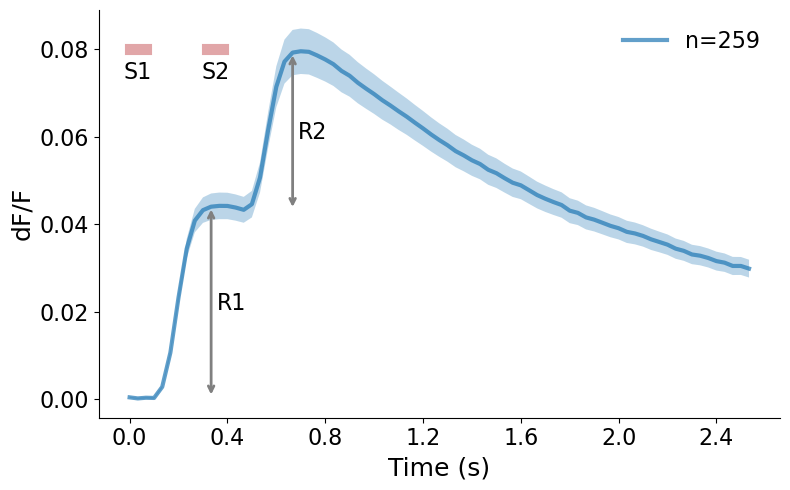

In [42]:
# trace_grand_avg = trace_grand_avg[:77]
# trace_grand_sem = trace_grand_sem[:77]

# plot trace avg and sem

plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,5))

plt.plot(trace_grand_avg, alpha=0.7, linewidth=3, \
    label='n={}'.format(trace_all.shape[0]))
plt.fill_between(np.arange(trace_grand_avg.shape[0]), \
        trace_grand_avg-trace_grand_sem, trace_grand_avg+trace_grand_sem, \
        alpha=0.3)

# # plot resp window
# plt.axvline(x=9, color='k', linestyle='--', linewidth=3, alpha=0.2)
# plt.axvline(x=11, color='k', linestyle='--', linewidth=3, alpha=0.2)
# plt.axvline(x=19, color='k', linestyle='--', linewidth=3, alpha=0.2)
# plt.axvline(x=21, color='k', linestyle='--', linewidth=3, alpha=0.2)

# plot stim resp arrow
base1_id = 0
stim1_id = 10
base2_id = 14
stim2_id = 20
plt.annotate(text='', xy=(stim1_id, trace_grand_avg[base1_id]), xytext=(stim1_id, trace_grand_avg[stim1_id]), \
            arrowprops=dict(arrowstyle='<->', linewidth=2, color='gray'));
plt.annotate(text='', xy=(stim2_id, trace_grand_avg[base2_id]), xytext=(stim2_id, trace_grand_avg[stim2_id]), \
            arrowprops=dict(arrowstyle='<->', linewidth=2, color='gray'));

# add text for arrow
buffer_space = 2.5
adjust_down_space = 0.003
plt.text(stim1_id + buffer_space, (trace_grand_avg[stim1_id] + trace_grand_avg[base1_id]) / 2 - adjust_down_space, \
        'R1', ha='center', va='bottom', fontsize=16)
plt.text(stim2_id + buffer_space, (trace_grand_avg[stim2_id] + trace_grand_avg[base2_id]) / 2 - adjust_down_space, \
        'R2', ha='center', va='bottom', fontsize=16)

# plot stim-on time
# 100 ms first stim (onset at 0 frame), 30 frame/sec -> 30*0.1 = 3 frames
# after 250 ms ISI, second stim onset: 0.25*30 = 7.5 frames
# 100 ms second stim: 0.1*30 = 3 frames
# first stim bar: frame 0 to frame 2
# second stim bar: frame 9.5 to frame 11.5
stim1_time = np.arange(0, 2, 0.01)
stim2_time = np.arange(9.5, 11.5, 0.01)
y = np.ones(stim1_time.shape) * 0.08
plt.plot(stim1_time, y, linewidth=8, color='r', alpha=0.5)
plt.plot(stim2_time, y, linewidth=8, color='r', alpha=0.5)

# text annotation for stim-on time
plt.text(1, 0.072, 'S1', ha='center', va='bottom', fontsize=16)
plt.text(10.5, 0.072, 'S2', ha='center', va='bottom', fontsize=16)

# change xticks to time in sec
frame_rate = 30 # frame per second
nlabel = 12
x = np.arange(0, trace_grand_avg.shape[0], nlabel)
time_sec = np.arange(0, trace_grand_avg.shape[0], nlabel) / frame_rate
labels = [str(t) for t in time_sec]
plt.xticks(x, labels, fontsize=16);
plt.yticks(fontsize=16)

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('dF/F', fontsize=18)
plt.grid(False)
plt.legend(frameon=False, fontsize=16);

ax = plt.gca() # spine off for right and top
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
# plt.savefig(dir_inter + '/results/student seminar/trace_grand_avg_resp_window_nat_img.pdf')
plt.savefig('trace_grand_avg_resp_window_nat_img.pdf')

In [23]:
trace_grand_avg_bunny = trace_grand_avg
trace_grand_sem_bunny = trace_grand_sem
ncell_bunny = trace_all.shape[0]
trace_all_bunny = trace_all

## grating

In [24]:
trace_by_trial_all = []

for i in np.arange(df_grat.shape[0]): # last 2 dataset used slow stim long ISI
    mouse = df_grat.iloc[i].mouse.astype(str)
    date = df_grat.iloc[i].date.astype(str)
    date = date + '_cellpose' if df_grat.iloc[i].cellpose_seg == 1 else date
    print(mouse, date)

    dir_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i{}_{}'.format(mouse, date)
    stim_id, trace_by_trial = adp.load_trace_trial_data(dir_path)

    trace_by_cell = np.mean(trace_by_trial, axis=1)
    trace_by_trial_all.append(trace_by_cell)
    
len(trace_by_trial_all), [trace_by_trial_all[i].shape for i in np.arange(len(trace_by_trial_all))]

1322 200803
ncell: 84, nstim: 8, ntrial: 21, nframe: 207
1323 200720
ncell: 43, nstim: 8, ntrial: 18, nframe: 206
1324 200728
ncell: 65, nstim: 8, ntrial: 25, nframe: 206
1328 201015
ncell: 44, nstim: 8, ntrial: 28, nframe: 207
1329 201209
ncell: 91, nstim: 8, ntrial: 20, nframe: 207
1337 210120_cellpose
ncell: 51, nstim: 8, ntrial: 25, nframe: 206


(6, [(84, 207), (43, 206), (65, 206), (44, 207), (91, 207), (51, 206)])

In [25]:
trial_len_min = np.min([trace_by_trial_all[i].shape[1] for i in np.arange(len(trace_by_trial_all))])
print(trial_len_min)
trace_by_trial_all = [trace_by_trial_all[i][:,:trial_len_min] for i in np.arange(len(trace_by_trial_all))]
print([trace_by_trial_all[i].shape for i in np.arange(len(trace_by_trial_all))])
trace_all = np.concatenate(trace_by_trial_all, axis=0)
trace_grand_avg = np.mean(trace_all, axis=0)
trace_grand_sem = np.std(trace_all, axis=0) / np.sqrt(trace_all.shape[0])
trace_all.shape, trace_grand_avg.shape, trace_grand_sem.shape

206
[(84, 206), (43, 206), (65, 206), (44, 206), (91, 206), (51, 206)]


((378, 206), (206,), (206,))

In [281]:
# plt.figure(figsize=(20, 5))
# plt.plot(trace_grand_avg, alpha=0.7, linewidth=3, \
#     label='n={}'.format(trace_all.shape[0]))
# plt.fill_between(np.arange(trace_grand_avg.shape[0]), \
#         trace_grand_avg-trace_grand_sem, trace_grand_avg+trace_grand_sem, \
#         alpha=0.3)
# plt.grid(b=True, which='both', color='0.65', linestyle='-')
# plt.xticks(np.arange(0, trace_grand_avg.shape[0]), rotation= 90)
# plt.xlim([-1, trace_grand_avg.shape[0]])
# plt.legend(frameon=False);

In [ ]:
# plt.rcParams.update(plt.rcParamsDefault)
# plt.figure(figsize=(8,5))
# plt.xticks(fontsize=16);
# plt.yticks(fontsize=16)

# plt.xlabel('Time (s)', fontsize=18)
# plt.ylabel('dF/F', fontsize=18)
# plt.grid(False)
# plt.legend(frameon=False, fontsize=16);

# ax = plt.gca() # spine off for right and top
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# plt.tight_layout()
# plt.savefig('trace_grand_avg_resp_window_nat_img.pdf')

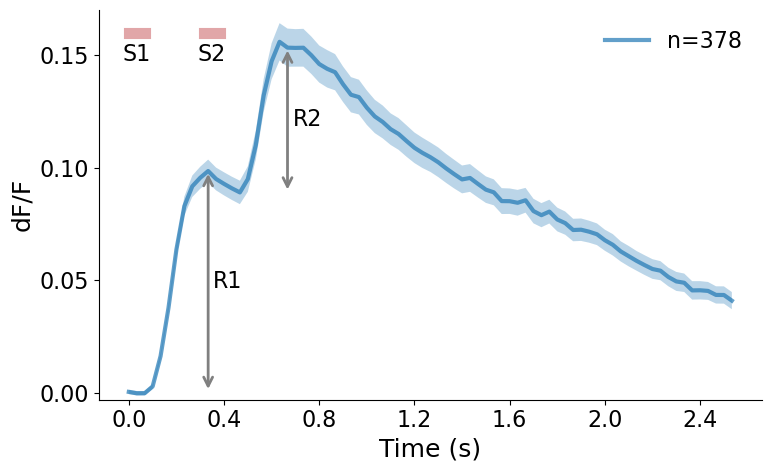

In [49]:
trace_grand_avg = trace_grand_avg[:77]
trace_grand_sem = trace_grand_sem[:77]

# plot trace avg and sem
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,5))
plt.plot(trace_grand_avg, alpha=0.7, linewidth=3, \
    label='n={}'.format(trace_all.shape[0]))
plt.fill_between(np.arange(trace_grand_avg.shape[0]), \
        trace_grand_avg-trace_grand_sem, trace_grand_avg+trace_grand_sem, \
        alpha=0.3)

# # plot resp window
# plt.axvline(x=9, color='k', linestyle='--', linewidth=3, alpha=0.2)
# plt.axvline(x=11, color='k', linestyle='--', linewidth=3, alpha=0.2)
# plt.axvline(x=19, color='k', linestyle='--', linewidth=3, alpha=0.2)
# plt.axvline(x=21, color='k', linestyle='--', linewidth=3, alpha=0.2)

# plot stim resp arrow
base1_id = 0
stim1_id = 10
base2_id = 14
stim2_id = 20
plt.annotate(text='', xy=(stim1_id, trace_grand_avg[base1_id]), xytext=(stim1_id, trace_grand_avg[stim1_id]), \
            arrowprops=dict(arrowstyle='<->', linewidth=2, color='gray'));
plt.annotate(text='', xy=(stim2_id, trace_grand_avg[base2_id]), xytext=(stim2_id, trace_grand_avg[stim2_id]), \
            arrowprops=dict(arrowstyle='<->', linewidth=2, color='gray'));

# add text for arrow
buffer_space = 2.5
adjust_down_space = 0.005
plt.text(stim1_id + buffer_space, (trace_grand_avg[stim1_id] + trace_grand_avg[base1_id]) / 2 - adjust_down_space, \
        'R1', ha='center', va='bottom', fontsize=16)
plt.text(stim2_id + buffer_space, (trace_grand_avg[stim2_id] + trace_grand_avg[base2_id]) / 2 - adjust_down_space, \
        'R2', ha='center', va='bottom', fontsize=16)

# plot stim-on time
# 100 ms first stim (onset at 0 frame), 30 frame/sec -> 30*0.1 = 3 frames
# after 250 ms ISI, second stim onset: 0.25*30 = 7.5 frames
# 100 ms second stim: 0.1*30 = 3 frames
# first stim bar: frame 0 to frame 2
# second stim bar: frame 9.5 to frame 11.5
stim1_time = np.arange(0, 2, 0.01)
stim2_time = np.arange(9.5, 11.5, 0.01)
y = np.ones(stim1_time.shape) * 0.16
plt.plot(stim1_time, y, linewidth=8, color='r', alpha=0.5)
plt.plot(stim2_time, y, linewidth=8, color='r', alpha=0.5)

# text annotation for stim-on time
plt.text(1, 0.145, 'S1', ha='center', va='bottom', fontsize=16)
plt.text(10.5, 0.145, 'S2', ha='center', va='bottom', fontsize=16)

# change xticks to time in sec
frame_rate = 30 # frame per second
nlabel = 12
x = np.arange(0, trace_grand_avg.shape[0], nlabel)
time_sec = np.arange(0, trace_grand_avg.shape[0], nlabel) / frame_rate
labels = [str(t) for t in time_sec]
plt.xticks(x, labels);
plt.yticks(np.arange(-0.1, 0.2, 0.05));
plt.grid(False)

plt.ylim([-0.003, 0.17])
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('dF/F', fontsize=18)
plt.grid(False)
plt.legend(frameon=False);

ax = plt.gca() # spine off for right and top
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('trace_grand_avg_resp_window_grat.pdf')

In [26]:
trace_grand_avg_grat = trace_grand_avg
trace_grand_sem_grat = trace_grand_sem
ncell_grat = trace_all.shape[0]
trace_all_grat = trace_all

In [27]:
ncell_grat, ncell_bunny, trace_all_grat.shape, trace_all_bunny.shape

(378, 259, (378, 206), (259, 77))

# trace compare bunny vs grating

## poster trace grat vs nat

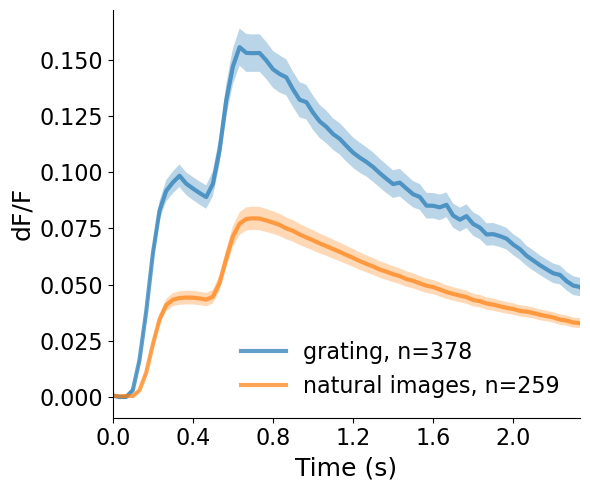

In [40]:
# plt default rcparams
plt.rcParams.update(plt.rcParamsDefault)

plt.figure(figsize=(6, 5))

plt.plot(trace_grand_avg_grat, alpha=0.7, linewidth=3, \
    label='grating, n={}'.format(ncell_grat))
plt.plot(trace_grand_avg_bunny, alpha=0.7, linewidth=3, \
    label='natural images, n={}'.format(ncell_bunny))

plt.fill_between(np.arange(trace_grand_avg_grat.shape[0]), \
        trace_grand_avg_grat-trace_grand_sem_grat, trace_grand_avg_grat+trace_grand_sem_grat, \
        alpha=0.3)
plt.fill_between(np.arange(trace_grand_avg_bunny.shape[0]), \
        trace_grand_avg_bunny-trace_grand_sem_bunny, trace_grand_avg_bunny+trace_grand_sem_bunny, \
        alpha=0.3)

# plt.axvline(x=8, color='k', linestyle='--', linewidth=3, alpha=0.2)
# plt.axvline(x=11, color='k', linestyle='--', linewidth=3, alpha=0.2)
# plt.axvline(x=19, color='k', linestyle='--', linewidth=3, alpha=0.2)
# plt.axvline(x=22, color='k', linestyle='--', linewidth=3, alpha=0.2)

# change xticks to time in sec
frame_rate = 30 # frame per second
nlabel = 12
x = np.arange(0, trace_grand_avg_bunny.shape[0], nlabel)
time_sec = np.arange(0, trace_grand_avg_bunny.shape[0], nlabel) / frame_rate
labels = [str(t) for t in time_sec]
plt.xticks(x, labels, fontsize=16);
plt.yticks(fontsize=16)
plt.xlim([0,70])

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('dF/F', fontsize=18)
plt.grid(False)
plt.legend(frameon=False, fontsize=16);

ax = plt.gca() # spine off for right and top
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('trace_grand_avg_compare_stim_type.pdf')

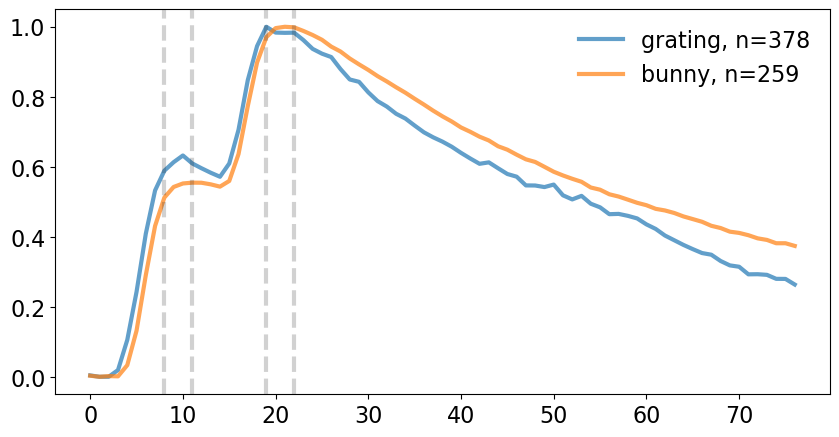

In [53]:
# normalize trace by maxmin
trace_grand_avg_grat_norm = (trace_grand_avg_grat - np.min(trace_grand_avg_grat)) / (np.max(trace_grand_avg_grat) - np.min(trace_grand_avg_grat))
trace_grand_avg_bunny_norm = (trace_grand_avg_bunny - np.min(trace_grand_avg_bunny)) / (np.max(trace_grand_avg_bunny) - np.min(trace_grand_avg_bunny))

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 5))
plt.plot(trace_grand_avg_grat_norm, alpha=0.7, linewidth=3, \
    label='grating, n={}'.format(ncell_grat))
plt.plot(trace_grand_avg_bunny_norm, alpha=0.7, linewidth=3, \
    label='bunny, n={}'.format(ncell_bunny))

plt.axvline(x=8, color='k', linestyle='--', linewidth=3, alpha=0.2)
plt.axvline(x=11, color='k', linestyle='--', linewidth=3, alpha=0.2)
plt.axvline(x=19, color='k', linestyle='--', linewidth=3, alpha=0.2)
plt.axvline(x=22, color='k', linestyle='--', linewidth=3, alpha=0.2)

plt.grid(False)
plt.legend(frameon=False);

# resp ad vs tg
read from trace_grand_avg plot:  
base window 1 = 0:2  
resp ad window = 8:11  
base window 2 = 13:15  
resp tg window = 19:22  

In [54]:
def get_resp_from_trace(trace_all):
    
    base1 = np.mean(trace_all[:,0:2+1], axis=1)
    resp_ad = np.mean(trace_all[:,8:11+1], axis=1)
    resp_ad = resp_ad - base1
    # resp_ad = np.log(resp_ad + 0.1)
    resp_ad_median = np.median(resp_ad)
    resp_ad_mean = np.mean(resp_ad)

    base2 = np.mean(trace_all[:,13:15+1], axis=1)
    resp_tg = np.mean(trace_all[:,19:22+1], axis=1)
    resp_tg = resp_tg - base2
    # resp_tg = np.log(resp_tg + 0.1)
    resp_tg_median = np.median(resp_tg)
    resp_tg_mean = np.mean(resp_tg)

    return resp_ad, resp_tg, resp_ad_median, resp_tg_median, resp_ad_mean, resp_tg_mean

## bunny

In [55]:
resp_ad_bunny, resp_tg_bunny, resp_ad_median_bunny, resp_tg_median_bunny, resp_ad_mean_bunny, resp_tg_mean_bunny = get_resp_from_trace(trace_all_bunny)
resp_ad_grat, resp_tg_grat, resp_ad_median_grat, resp_tg_median_grat, resp_ad_mean_grat, resp_tg_mean_grat = get_resp_from_trace(trace_all_grat)

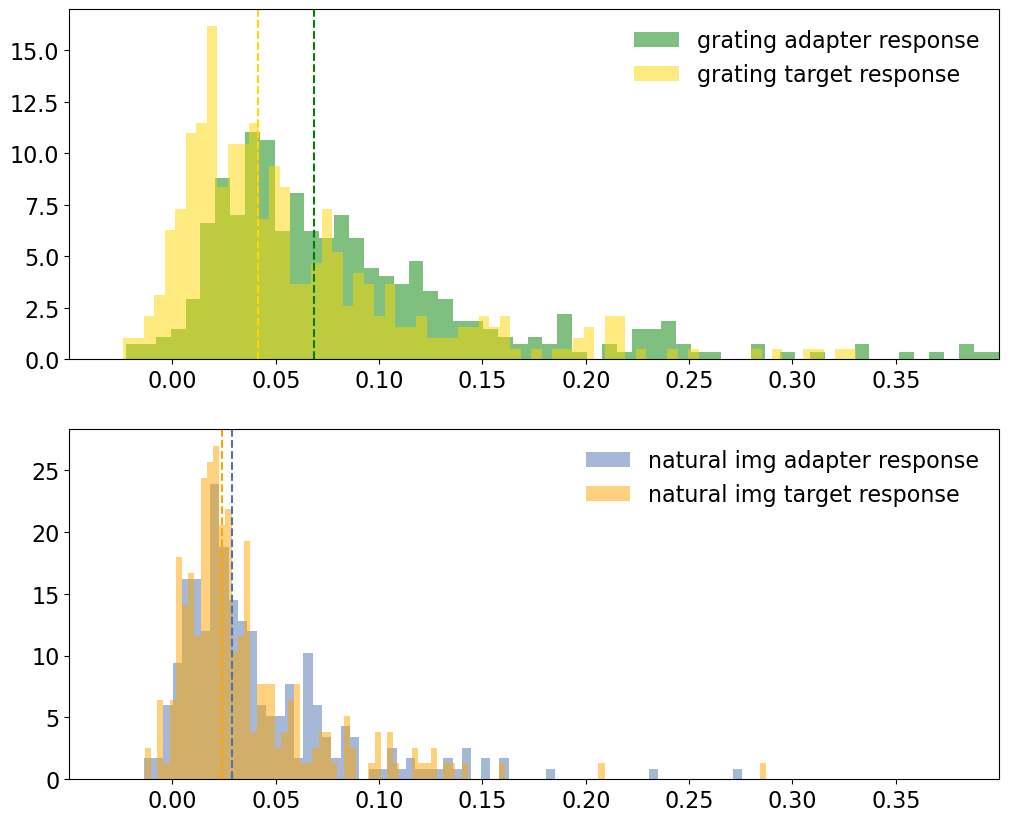

In [56]:
plt.figure(figsize=(12, 10))

plt.subplot(2,1,1)
plt.hist(resp_ad_grat, bins=100, alpha=0.5, label='grating adapter response', color='green', density=True);
plt.hist(resp_tg_grat, bins=100, alpha=0.5, label='grating target response', color='gold', density=True);
plt.axvline(x=resp_ad_median_grat, color='green', linestyle='--')
plt.axvline(x=resp_tg_median_grat, color='gold', linestyle='--')
plt.xlim([-0.05, 0.4])
plt.legend(frameon=False)
plt.xticks(np.arange(-0, 0.40, 0.05))
plt.grid(False);

plt.subplot(2,1,2)
plt.hist(resp_ad_bunny, bins=100, alpha=0.5, label='natural img adapter response', color='b', density=True);
plt.hist(resp_tg_bunny, bins=100, alpha=0.5, label='natural img target response', color='orange', density=True);
plt.axvline(x=resp_ad_median_bunny, color='b', linestyle='--')
plt.axvline(x=resp_tg_median_bunny, color='orange', linestyle='--')
plt.xlim([-0.05, 0.4])
plt.legend(frameon=False)
plt.xticks(np.arange(-0, 0.40, 0.05));
plt.grid(False);

# plt.savefig(dir_inter + '/results/student seminar/hist_resp_ad_vs_tg_compare_stim.pdf')

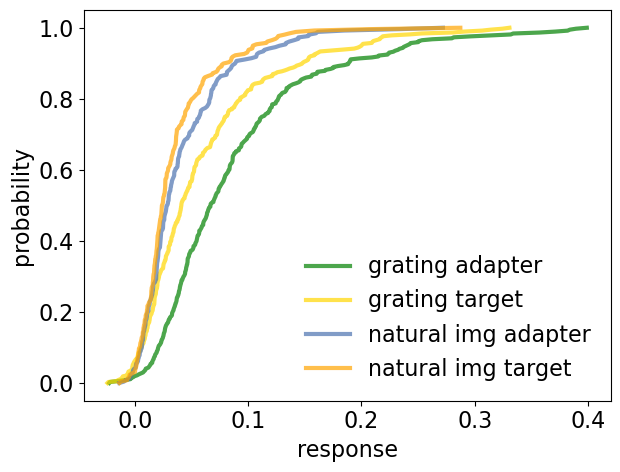

In [57]:
resp_thres_grat = 0.4
resp_ad_sorted_grat = np.sort(resp_ad_grat[resp_ad_grat < resp_thres_grat])
resp_tg_sorted_grat = np.sort(resp_tg_grat[resp_tg_grat < resp_thres_grat])
p_ad_grat = 1. * np.arange(len(resp_ad_sorted_grat)) / (len(resp_ad_sorted_grat) - 1)
p_tg_grat = 1. * np.arange(len(resp_tg_sorted_grat)) / (len(resp_tg_sorted_grat) - 1)

resp_thres_bunny = 0.4
resp_ad_sorted_bunny = np.sort(resp_ad_bunny[resp_ad_bunny < resp_thres_bunny])
resp_tg_sorted_bunny = np.sort(resp_tg_bunny[resp_tg_bunny < resp_thres_bunny])
p_ad_bunny = 1. * np.arange(len(resp_ad_sorted_bunny)) / (len(resp_ad_sorted_bunny) - 1)
p_tg_bunny = 1. * np.arange(len(resp_tg_sorted_bunny)) / (len(resp_tg_sorted_bunny) - 1)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax1.plot(resp_ad_sorted_grat, p_ad_grat, label='grating adapter', linewidth=3, alpha=0.7, color='green')
ax1.plot(resp_tg_sorted_grat, p_tg_grat, label='grating target', linewidth=3, alpha=0.7, color='gold')
ax1.plot(resp_ad_sorted_bunny, p_ad_bunny, label='natural img adapter', linewidth=3, alpha=0.7, color='b')
ax1.plot(resp_tg_sorted_bunny, p_tg_bunny, label='natural img target', linewidth=3, alpha=0.7, color='orange')
ax1.set_xlabel('response')
ax1.set_ylabel('probability')

plt.grid(False)
plt.legend(frameon=False, loc='lower right');
plt.tight_layout()
# plt.savefig(dir_inter + '/results/student seminar/cdf_resp_ad_vs_tg_compare_stim.pdf')

# adaptation distribution

In [58]:
def get_adp_from_resp(resp_ad, resp_tg):
    adp = (resp_tg - resp_ad) / (resp_ad + 1e-7)

    # discard top and bottom percentiles
    adp_sorted = np.sort(adp)
    discard_perc = 0.02
    adp_middle = adp_sorted[int(discard_perc*len(adp_sorted)) : int((1-discard_perc)*len(adp_sorted))]
    adp_median = np.median(adp_middle)
    adp_mean = np.mean(adp_middle)

    return adp_middle, adp_median, adp_mean

In [59]:
adp_middle_bunny, adp_median_bunny, adp_mean_bunny = get_adp_from_resp(resp_ad_bunny, resp_tg_bunny)
adp_middle_grat, adp_median_grat, adp_mean_grat = get_adp_from_resp(resp_ad_grat, resp_tg_grat)

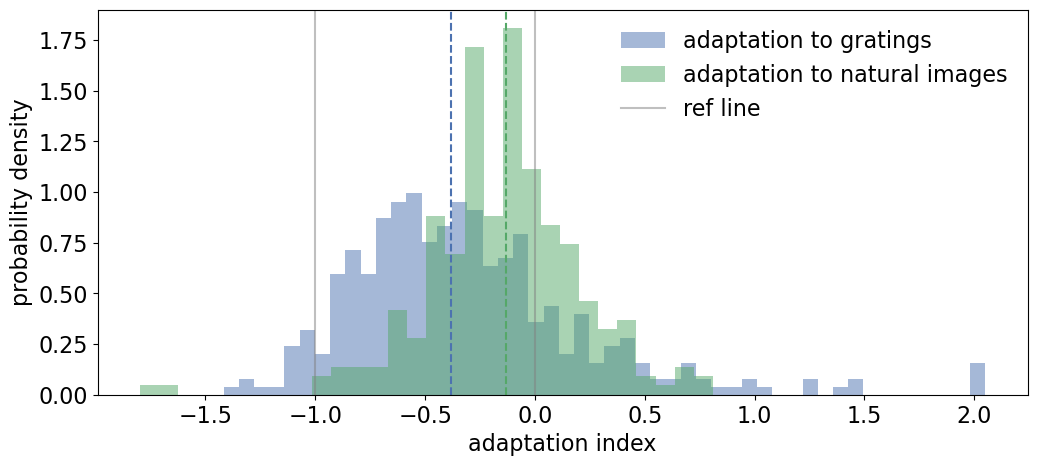

In [60]:
plt.figure(figsize=(12, 5))

plt.hist(adp_middle_grat, bins=50, alpha=0.5, color='b', label='adaptation to gratings', \
        density=True, stacked=True); # sum of histograms is normalized to 1
plt.axvline(x=adp_median_grat, color='b', linestyle='--')

plt.hist(adp_middle_bunny, bins=30, alpha=0.5, color='g', label='adaptation to natural images', \
        density=True, stacked=True);
plt.axvline(x=adp_median_bunny, color='g', linestyle='--')

plt.axvline(x=0, color='gray', linestyle='-', label='ref line', alpha=0.5)
plt.axvline(x=-1, color='gray', linestyle='-', alpha=0.5)

plt.xlabel('adaptation index')
# plt.xticks(np.arange(-5, 4, 1))
plt.ylabel('probability density')
plt.grid(False)
plt.legend(frameon=False);

# plt.savefig(dir_inter + '/results/student seminar/adaptation_compare_stim.pdf')

In [61]:
# ttest_ind for adaptation to grat vs bunny

from scipy.stats import ttest_ind 
# test for the null hypothesis that 2 independent samples have identical average (expected) values. 

t, p = ttest_ind(adp_middle_grat, adp_middle_bunny, equal_var=False) # perform Welch’s t-test, which does not assume equal population variance
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = -4.4475  p = 1.03367e-05


In [62]:
# build df for sns
df_adp_grat = pd.DataFrame({'adp': adp_middle_grat})
df_adp_grat['stim_type'] = 'grat'
df_adp_bunny = pd.DataFrame({'adp': adp_middle_bunny})
df_adp_bunny['stim_type'] = 'bunny'
# df_adp_placeholder = pd.DataFrame({'adp': adp_middle_bunny}) # here to beautify violin plot, didn't seem to help
# df_adp_placeholder['stim_type'] = 'none'
df_adp = pd.concat([df_adp_grat, df_adp_bunny]) # , df_adp_placeholder
df_adp

,adp,stim_type
0,-1.417678,grat
1,-1.297798,grat
2,-1.287449,grat
3,-1.252720,grat
4,-1.152326,grat
...,...,...
243,0.641524,bunny
244,0.645448,bunny
245,0.672685,bunny
246,0.774905,bunny


In [63]:
"""Violin plot with just the median drawn
By default, when plotting a split violin plot, the inner
box plot is for both splits. You can change this with `inner='quartile'`
to plot the quartiles for each split, but by default it uses a dashed
line (small dashes) for the 25 and 75-%ile and another dashed line
(big dashes) for the median, which is very ugly and cluttered.
This patching the `draw_quartiles` function to just draw the median
as a solid line.
This only works with seaborn 0.8. It does not work with seaborn 0.7
(init args have changed in `_ViolinPlotter`, as is their wont)

https://gist.github.com/mpharrigan/a4375afa71d560dbdf3a0d96552a1cd5
"""

from seaborn.categorical import _ViolinPlotter
import numpy as np
from matplotlib import pyplot as plt


class MyVPlot(_ViolinPlotter):
    def draw_quartiles(self, ax, data, support, density, center, split=False):
        """Draw the quartiles as lines at width of density."""
        q25, q50, q75 = np.percentile(data, [25, 50, 75])
        self.draw_to_density(ax, center, q50, support, density, split,
                             linewidth=self.linewidth, )


def my_violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
                  bw="scott", cut=2, scale="area", scale_hue=True, gridsize=100,
                  width=.8, inner="box", split=False, dodge=True, orient=None,
                  linewidth=None, color=None, palette=None, saturation=.75,
                  ax=None, **kwargs):
    plotter = MyVPlot(x, y, hue, data, order, hue_order,
                      bw, cut, scale, scale_hue, gridsize,
                      width, inner, split, dodge, orient, linewidth,
                      color, palette, saturation)
    if ax is None:
        ax = plt.gca()

    plotter.plot(ax)
    return ax

## poster violin plot: adp grat vs nat

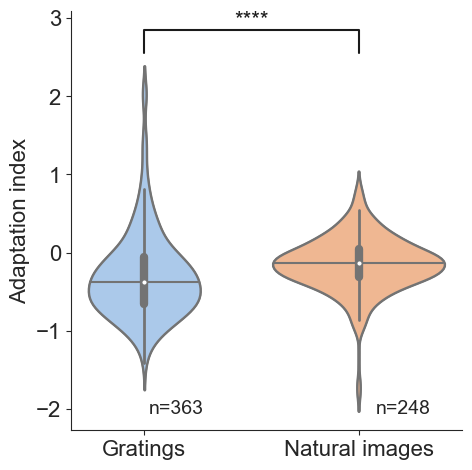

In [91]:
## make histogram into violin plot

plt.figure(figsize=(5, 5))
sns.set_style("ticks")
ax = sns.violinplot(x="stim_type", y="adp",
                data=df_adp, kind="violin", height=4, aspect=1, linewidth=2,
                palette='pastel', inner="box",);
ax = my_violinplot(x="stim_type", y="adp", data=df_adp, palette='pastel',
                  inner='quartile'); # only plot inner median as a horiz spine, using my_violinplot

# statistical annotation
x1, x2 = 0, 1
y, h, col = np.max(df_adp.adp.values) + 0.5, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

# text annotation
plt.text(0.27, 0.03, f'n={adp_middle_grat.shape[0]}', ha='center', va='bottom', transform=ax.transAxes, fontsize=14)
plt.text(0.85, 0.03, f'n={adp_middle_bunny.shape[0]}', ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

plt.xlabel('')
# ax.set_xlim([-0.5,2.5])
plt.ylabel('Adaptation index', fontsize=16)
ax.set_xticklabels(['Gratings', 'Natural images'], fontsize=18) # , 'placeholder'

ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
sns.despine(ax=ax)
plt.tight_layout()
plt.savefig('adaptation_compare_grat_nat_violin.pdf')

# figtitle = 'Adaptation magnitude increases along ventral stream'
# ax.fig.suptitle(figtitle, size=16)
# ax.fig.subplots_adjust(top=.8)
# plt.savefig(r'C:\Users\GlickfeldLab\Documents\test\inter\results\student seminar\Adaptation magnitude stim type.pdf', format='pdf')

# vis filter

In [470]:
def vis_driven_prob(dfof_ad_trial):

    p_anova = np.ones((ncell, 1)) * np.nan
    p_kruskal = np.ones((ncell, 1)) * np.nan
    p_ttest = np.ones((ncell, nstim)) * np.nan
    evoked = np.ones((ncell, nstim)) * np.nan

    for icell in tqdm(np.arange(ncell)):
        base_cell_anova = np.concatenate([dfof_trialwise['dfof_base_trial'][icell, stim] for stim in range(nstim)])
        stim_cell_anova = [] 
        for istim in np.arange(nstim):
            stim_cell_anova.append(np.array(dfof_ad_trial[icell, istim]).flatten())

            base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
            stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
            _, p_ttest_i = stats.ttest_ind(base_cell.flatten(), stim_cell.flatten(), equal_var=False, alternative='less')
            p_ttest[icell, istim] = p_ttest_i

            evoked_cell = (stim_cell - base_cell) / (base_cell + 1e-7)
            evoked_i = np.mean(evoked_cell, axis=0) # trial averaged evoked resp
            evoked[icell, istim] = evoked_i
        
        _, p_anova_cell = stats.f_oneway(np.array(base_cell_anova).flatten(), *stim_cell_anova)
        p_anova[icell] = p_anova_cell
        _, p_kruskal_cell = stats.kruskal(np.array(base_cell_anova).flatten(), *stim_cell_anova)
        p_kruskal[icell] = p_kruskal_cell

    return p_anova, p_kruskal, p_ttest, evoked

In [475]:
def vis_driven_bool(p_anova, p_kruskal, p_ttest, evoked, p_sig=0.01, dir_save=None):
    # visually driven cells: pass (anova OR kruskal) AND amp threshold for >=1 image
    ncell = len(p_anova)
    vis_driven = ((p_anova < p_sig) | (p_kruskal < p_sig)) & (sum(evoked.T > 0.1) > 0).reshape(-1, 1)
    print(f'{vis_driven.sum()} cells are visually driven, \n\
        proportion {np.round(vis_driven.sum()/ncell, 2)} out of {ncell} cells')

    if dir_save is not None:
        with open(dir_save + '/vis_driven.pickle', 'wb') as f:
            mydict = {'p_anova': p_anova, 'p_kruskal': p_kruskal, 'p_ttest': p_ttest, 'evoked': evoked, 'vis_driven': vis_driven}
            pickle.dump(mydict, f, protocol=pickle.HIGHEST_PROTOCOL)
    # with open('filename.pickle', 'rb') as handle:
    #     b = pickle.load(handle)
    
    # cells responsive to image i: pass visually driven (anova OR kruskal) AND t-test AND amp threshold for *this* image
    # img_driven = vis_driven & (p_ttest < p_sig) & (evoked > 0.1)
    # print(f'{img_driven.sum()} cells are image driven - with overlap between images, \n\
    #     proportion {np.round(img_driven.sum() / (ncell*nstim), 2)} out of {ncell*nstim} cell-stim combos. \n\
    #     >=1 image evokes resp from {np.sum(img_driven, axis=0)} cells')

    # t = np.sum(img_driven, axis=1)
    # print(f'img driven cells are driven by {t[t>0]} images')
    return vis_driven, #img_driven

In [478]:
# batch run vis filter: input resp_base_trialwise.mat, output vis_driven.pickle

dir_inter = r'C:\Users\GlickfeldLab\Documents\test\inter'.replace('\\', '/')
df = pd.read_csv(dir_inter + '/data/batch_cellpose.csv')
df = df[(df.manual_seg == 1) | (df.cellpose_seg == 1)].reset_index(drop=True)
df

nset = df.shape[0]
for i in np.arange(nset):
    print('set ', i+1, 'of', nset)
    mouse = df.iloc[i].mouse.astype(str)
    imouse = 'i' + mouse
    date = df.iloc[i].date.astype(str)
    date = date + '_cellpose' if df.iloc[i].cellpose_seg == 1 else date
    # print(imouse, date)

    # load data from mat_inter
    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')
    dir_set = dir_data + '/' + 'V1_' + imouse + '_' + date
    print(dir_set) # \\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1350_220225_cellpose
    
    mat_file = dir_set + '/' + 'resp_base_trialwise.mat'
    dfof_trialwise = sio.loadmat(mat_file)
    # print(dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape)
    dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] # do not subtract baseline here: stim resp will be compared to base resp
    
    # find vis driven cell
    ncell = dfof_ad_trial.shape[0]
    nstim = dfof_ad_trial.shape[1]
    p_anova, p_kruskal, p_ttest, evoked = vis_driven_prob(dfof_ad_trial)
    vis_driven = vis_driven_bool(p_anova, p_kruskal, p_ttest, evoked, p_sig=0.01, dir_save=dir_set)

set  1 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1338_210616_cellpose
(77, 7) (190, 1)


100%|██████████| 77/77 [00:00<00:00, 463.74it/s]


75 cells are visually driven, 
        proportion 0.97 out of 77 cells
set  2 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1339_210922_cellpose
(95, 500) (3, 1)


100%|██████████| 95/95 [00:10<00:00,  9.29it/s]


95 cells are visually driven, 
        proportion 1.0 out of 95 cells
set  3 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1350_211222_cellpose
(80, 30) (16, 1)


100%|██████████| 80/80 [00:00<00:00, 144.50it/s]


70 cells are visually driven, 
        proportion 0.88 out of 80 cells
set  4 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1350_220225_cellpose
(19, 30) (19, 1)


100%|██████████| 19/19 [00:00<00:00, 143.90it/s]


19 cells are visually driven, 
        proportion 1.0 out of 19 cells
set  5 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1369_220310_cellpose
(114, 30) (17, 1)


100%|██████████| 114/114 [00:00<00:00, 145.33it/s]


111 cells are visually driven, 
        proportion 0.97 out of 114 cells
set  6 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1372_220406_cellpose
(131, 30) (21, 1)


100%|██████████| 131/131 [00:00<00:00, 144.76it/s]


122 cells are visually driven, 
        proportion 0.93 out of 131 cells
set  7 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1322_200803
(97, 8) (21, 1)


100%|██████████| 97/97 [00:00<00:00, 479.98it/s]


84 cells are visually driven, 
        proportion 0.87 out of 97 cells
set  8 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1323_200720
(103, 8) (18, 1)


100%|██████████| 103/103 [00:00<00:00, 481.18it/s]


43 cells are visually driven, 
        proportion 0.42 out of 103 cells
set  9 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1324_200728
(93, 8) (25, 1)


100%|██████████| 93/93 [00:00<00:00, 481.74it/s]


65 cells are visually driven, 
        proportion 0.7 out of 93 cells
set  10 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1328_201015
(82, 8) (28, 1)


100%|██████████| 82/82 [00:00<00:00, 477.60it/s]


44 cells are visually driven, 
        proportion 0.54 out of 82 cells
set  11 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1329_201209
(146, 8) (20, 1)


100%|██████████| 146/146 [00:00<00:00, 483.33it/s]


91 cells are visually driven, 
        proportion 0.62 out of 146 cells
set  12 of 12
Z:/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1337_210120_cellpose
(62, 8) (25, 1)


100%|██████████| 62/62 [00:00<00:00, 473.17it/s]

51 cells are visually driven, 
        proportion 0.82 out of 62 cells


# vis trace (caiman vs manual)

In [18]:
def load_vis(dir_path):
    with open(dir_path + '/vis_driven.pickle', 'rb') as f:
        p_anova, p_kruskal, evoked, p_ttest = pickle.load(f)
    
    # visually driven cells: pass (anova OR kruskal) AND amp threshold for >=1 image
    p_sig = 0.01
    ncell = len(p_anova)
    nstim = 30 
    
    vis_driven = ((p_anova < p_sig) | (p_kruskal < p_sig)) & (sum(evoked.T > 0.1) > 0).reshape(-1, 1)
    print(f'{vis_driven.sum()} cells are visually driven, \n\
        proportion {np.round(vis_driven.sum()/ncell, 2)} out of {ncell} cells')

    # cells responsive to image i: pass visually driven (anova OR kruskal) AND t-test AND amp threshold for *this* image
    img_driven = vis_driven & (p_ttest < p_sig) & (evoked > 0.1)
    print(f'{img_driven.sum()} cells are image driven - with overlap between images, \n\
        proportion {np.round(img_driven.sum() / (ncell*nstim), 2)} out of {ncell*nstim} cell-stim combos. \n\
        1-30 image evokes resp from {np.sum(img_driven, axis=0)} cells')

    t = np.sum(img_driven, axis=1)
    print(f'img driven cells are driven by {t[t>0]} images')

    return vis_driven, img_driven

In [20]:
# high res V1 bunnytop, young mouse, manual segmentation
dir_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1369_220310'
stim_id_young_manual, trace_by_trial_young_manual = load_data(dir_path)
# vis_driven_young_manual, img_driven_young_manual = load_vis(dir_path)
vis_trace_by_trial_young_manual = trace_by_trial_young_manual#[vis_driven_young_manual.flatten(), :, :]
trace_avg_cell_young_manual, trace_stim_avg_young_manual = calc_trace_stim(vis_trace_by_trial_young_manual, stim_id_young_manual)

# high res V1 bunnytop, young mouse, midway
dir_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1369_220310_midway'
stim_id_young_midway, trace_by_trial_young_midway = load_data(dir_path)
vis_driven_young_midway, img_driven_young_midway = load_vis(dir_path)
vis_trace_by_trial_young_midway = trace_by_trial_young_midway[vis_driven_young_midway.flatten(), :, :]
trace_avg_cell_young_midway, trace_stim_avg_young_midway = calc_trace_stim(vis_trace_by_trial_young_midway, stim_id_young_midway)

# high res V1 bunnytop, young mouse, caiman segmentation
dir_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1369_220310_caiman'
stim_id_young_caiman, trace_by_trial_young_caiman = load_data(dir_path)
vis_driven_young_caiman, img_driven_young_caiman = load_vis(dir_path)
vis_trace_by_trial_young_caiman = trace_by_trial_young_caiman[vis_driven_young_caiman.flatten(), :, :]
trace_avg_cell_young_caiman, trace_stim_avg_young_caiman = calc_trace_stim(vis_trace_by_trial_young_caiman, stim_id_young_caiman)


155 30 511 156
30 (156,)
258 30 1022 156
108 cells are visually driven, 
        proportion 0.42 out of 258 cells
18 cells are image driven - with overlap between images, 
        proportion 0.0 out of 7740 cell-stim combos. 
        1-30 image evokes resp from [0 0 0 0 0 0 1 0 2 0 1 1 0 0 2 2 0 0 0 0 1 1 1 2 1 1 0 0 1 1] cells
img driven cells are driven by [2 1 1 1 1 1 1 1 1 1 3 1 2 1] images
30 (156,)
256 30 1022 156
124 cells are visually driven, 
        proportion 0.48 out of 256 cells
33 cells are image driven - with overlap between images, 
        proportion 0.0 out of 7680 cell-stim combos. 
        1-30 image evokes resp from [0 1 2 0 0 3 2 0 2 0 3 0 0 0 3 0 0 4 3 2 0 2 1 1 0 0 2 1 1 0] cells
img driven cells are driven by [2 1 2 3 2 1 1 1 1 2 1 1 1 3 1 2 1 2 2 1 2] images
30 (156,)


In [21]:
# with open(dir_path + '/vis_driven.pickle', 'rb') as f:
#     x = pickle.load(f)

# x.shape, trace_by_trial_young_manual.shape

trace_avg_cell_young_manual = (trace_avg_cell_young_manual - min(trace_avg_cell_young_manual)) / (max(trace_avg_cell_young_manual) - min(trace_avg_cell_young_manual))
trace_avg_cell_young_midway = (trace_avg_cell_young_midway - min(trace_avg_cell_young_midway)) / (max(trace_avg_cell_young_midway) - min(trace_avg_cell_young_midway))
trace_avg_cell_young_caiman = (trace_avg_cell_young_caiman - min(trace_avg_cell_young_caiman)) / (max(trace_avg_cell_young_caiman) - min(trace_avg_cell_young_caiman))

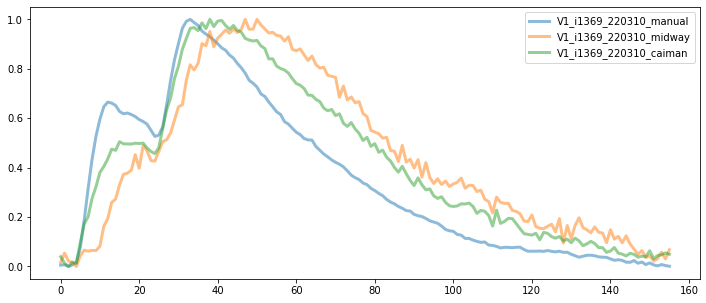

In [22]:
plt.figure(figsize=(12, 5))

# plt.subplot(2,1,1)
# plt.plot(trace_avg_cell, alpha=0.8, linewidth=3)
# plt.plot(trace_avg_cell_highres, alpha=0.2, linewidth=3)
# plt.plot(trace_avg_cell_manual, alpha=0.8, linewidth=3)
# plt.plot(trace_avg_cell_young, alpha=0.8, linewidth=3, linestyle='--')
plt.plot(trace_avg_cell_young_manual, alpha=0.5, linewidth=3)
plt.plot(trace_avg_cell_young_midway, alpha=0.5, linewidth=3)
plt.plot(trace_avg_cell_young_caiman, alpha=0.5, linewidth=3)

plt.legend([#'V1_i1350_211222', 'V1_i1350_220225', 'V1_i1350_220225_manual', 
            # 'V1_i1369_220310', 
            'V1_i1369_220310_manual', 'V1_i1369_220310_midway', 'V1_i1369_220310_caiman']);

# plt.subplot(2,1,2)
# plt.plot(trace_avg_cell, alpha=0.8, linewidth=3)
# plt.plot(- trace_avg_cell_highres + 0.035, alpha=0.8, linewidth=3)
# plt.plot((trace_avg_cell - 0.016) * 1.3, alpha=0.8, linewidth=3)
# plt.plot(- trace_avg_cell_highres + 0.035 - 0.016, alpha=0.8, linewidth=3)

# fano factor (nat vs grat)

In [23]:
def read_csv_by_stim_type():
    """
    read csv file containing metadata of recordings, including stim type 

    returns:
        df (pandas dataframe): dataframe of recordings for each stim type
    """
    # read metadata of segmented sessions
    dir_inter = r"C:\Users\GlickfeldLab\Documents\test\inter".replace("\\", "/")
    df = pd.read_csv(dir_inter + "/data/batch_cellpose.csv")
    # only keep segmented data
    df = df[(df.manual_seg == 1) | (df.cellpose_seg == 1)].reset_index(drop=True)
    # separate by stim type
    df_bun = df[df["stim_type"] == "bunny"]
    df_grat = df[(df["stim_type"] == "grating")]
    return df, df_bun, df_grat

def calc_fano_factor(arr):
    return np.std(arr, axis=0) / np.mean(arr, axis=0)

In [70]:
# batch run vis filter: input resp_base_trialwise.mat, output vis_driven.pickle

df, df_bun, df_grat = read_csv_by_stim_type()
nset = df.shape[0]

fano_ad_dataset = []
fano_tg_dataset = []
for i in np.arange(nset):
    print('set ', i+1, 'of', nset)
    mouse = df.iloc[i].mouse.astype(str)
    imouse = 'i' + mouse
    date = df.iloc[i].date.astype(str)
    date = date + '_cellpose' if df.iloc[i].cellpose_seg == 1 else date

    # load data from mat_inter
    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')
    dir_set = dir_data + '/' + 'V1_' + imouse + '_' + date
    print('V1_' + imouse + '_' + date)
    
    mat_file = dir_set + '/' + 'resp_base_trialwise.mat'
    dfof_trialwise = sio.loadmat(mat_file)
    # print(dfof_trialwise.keys())
    # print(dfof_trialwise['dfof_ad_trial'].shape) # ncell, nstim
    # print(dfof_trialwise['dfof_ad_trial'][0,0].shape) # ntrial for each cellxstim combo

    # vis filter # TODO: functionize
    with open(dir_set + "/vis_driven.pickle", "rb") as handle:
        vis = pickle.load(handle)
        vis_driven = vis["vis_driven"]
        vis_driven = [v[0] for v in vis_driven]  # flatten list
        
    dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] - dfof_trialwise['dfof_base_trial'] # subtract baseline
    dfof_tg_trial = dfof_trialwise['dfof_tg_trial'] - dfof_trialwise['dfof_base2_trial']
    dfof_ad_trial = dfof_ad_trial[vis_driven, :] # only keep trace of vis-driven cells
    dfof_tg_trial = dfof_tg_trial[vis_driven, :]
    ncell = dfof_ad_trial.shape[0]
    nstim = dfof_ad_trial.shape[1]
    print(f'ncell: {ncell}, nstim: {nstim}')

    if nstim > 30:
        print('skipping set')
        continue

    # fano factor of dfof_ad_trial & dfof_tg_trial, across each cell x stim
    fano_ad = np.zeros((ncell, nstim))
    fano_tg = np.zeros((ncell, nstim))
    for i in np.arange(ncell):
        for j in np.arange(nstim):
            fano_ad[i,j] = calc_fano_factor(dfof_ad_trial[i,j])
            fano_tg[i,j] = calc_fano_factor(dfof_tg_trial[i,j])
    fano_ad_stim = np.mean(fano_ad, axis=0) # avg across cells
    fano_tg_stim = np.mean(fano_tg, axis=0)
    fano_ad_dataset.append(fano_ad_stim)
    fano_tg_dataset.append(fano_tg_stim)
    
len(fano_ad_dataset), fano_ad_dataset[-1].shape

set  1 of 12
V1_i1338_210616_cellpose
ncell: 75, nstim: 7
set  2 of 12
V1_i1339_210922_cellpose
ncell: 95, nstim: 500
skipping set
set  3 of 12
V1_i1350_211222_cellpose
ncell: 70, nstim: 30
set  4 of 12
V1_i1350_220225_cellpose
ncell: 19, nstim: 30
set  5 of 12
V1_i1369_220310_cellpose
ncell: 111, nstim: 30
set  6 of 12
V1_i1372_220406_cellpose
ncell: 122, nstim: 30
set  7 of 12
V1_i1322_200803
ncell: 84, nstim: 8
set  8 of 12
V1_i1323_200720
ncell: 43, nstim: 8
set  9 of 12
V1_i1324_200728
ncell: 65, nstim: 8
set  10 of 12
V1_i1328_201015
ncell: 44, nstim: 8
set  11 of 12
V1_i1329_201209
ncell: 91, nstim: 8
set  12 of 12
V1_i1337_210120_cellpose
ncell: 51, nstim: 8


(11, (8,))

In [71]:
[len(arr) for arr in fano_ad_dataset]

[7, 30, 30, 30, 30, 8, 8, 8, 8, 8, 8]

In [73]:
[np.median(arr) for arr in fano_ad_dataset]

[1.5365158315838472,
 2.0203257960254204,
 2.574552088753535,
 1.61913727105853,
 1.55041504945696,
 1.922173359961962,
 3.1396636545970633,
 1.5088353657205296,
 1.6689430971974766,
 2.931365394107342,
 1.5395044175627806]

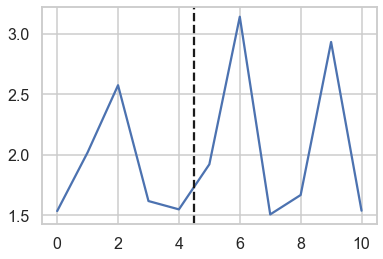

In [80]:
fano_ad_median = [np.median(arr) for arr in fano_ad_dataset]
plt.plot(fano_ad_median)
plt.axvline(x=4.5, linestyle='--', color='k')

In [81]:
df

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,stim_type
0,1338,210616,V1,200,2.0,1.0,NaN,bunny6,6s,bunny
1,1339,210922,V1,200,2.0,1.0,NaN,bunny500,6s,bunny
2,1350,211222,V1,200,2.0,1.0,NaN,bunnytop,6s,bunny
3,1350,220225,V1,200,2.0,1.0,NaN,bunnytop high res,6s,bunny
4,1369,220310,V1,200,2.0,1.0,NaN,bunnytop high res,6s,bunny
5,1372,220406,V1,200,2.0,1.0,NaN,bunnytop high res high lum-contrast,6s,bunny
6,1322,200803,V1,200,2.0,NaN,1.0,grating,6s,grating
7,1323,200720,V1,200,3.0,NaN,1.0,grating,6s,grating
8,1324,200728,V1,200,3.0,NaN,1.0,grating,6s,grating
9,1328,201015,V1,200,4.0,NaN,1.0,grating,6s,grating
